In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate

In [2]:
def make_batch_grids(x, y, z, batch_size, train_size, DM_size):
    # x,y,z range are coordinates ranges of each training cube
    x_range = ((x.reshape(batch_size,-1)+(np.arange(train_size[0])-(train_size[0]-1)/2)+DM_size)%DM_size).astype('int')
    y_range = ((y.reshape(batch_size,-1)+(np.arange(train_size[1])-(train_size[1]-1)/2)+DM_size)%DM_size).astype('int')
    z_range = ((z.reshape(batch_size,-1)+(np.arange(train_size[2])-(train_size[2]-1)/2)+DM_size)%DM_size).astype('int')
    
    # cx,cy,cz are coordinates of every points of each training cube, together forming a meshgrid
    ci = np.array([0,1,2,3]).repeat(train_size.prod()*batch_size).reshape(4,batch_size,train_size[0],train_size[1],train_size[2]).transpose(1,0,2,3,4)
    cx = x_range.repeat(train_size[[1,2]].prod()).reshape(batch_size,1,train_size[1],train_size[0],train_size[2]).transpose(0,1,2,3,4).repeat(4, axis=1)
    cy = y_range.repeat(train_size[[2,0]].prod()).reshape(batch_size,1,train_size[0],train_size[2],train_size[1]).transpose(0,1,4,2,3).repeat(4, axis=1)
    cz = z_range.repeat(train_size[[0,1]].prod()).reshape(batch_size,1,train_size[2],train_size[0],train_size[1]).transpose(0,1,3,4,2).repeat(4, axis=1)
    
    return tuple([ci,cx, cy, cz])

In [3]:
# read in DM cube
DM_fits = fits.open('Illustris3/DMdelta_Illustris3_L75_N600.fits')
DM = DM_fits[0].data + 1
DM_fits.close(); del DM_fits
DM_len  = 75*1000 # in kpc/h
DM_reso = DM_len / 600 # in kpc/h

DM_vx_fits = fits.open('Illustris3/vx_cic_Illustris3_L75_N600.fits')
DM_vx = DM_vx_fits[0].data
DM_vx = DM_vx/np.absolute(DM_vx[1]).mean()
DM_vx_fits.close(); del DM_vx_fits

DM_vy_fits = fits.open('Illustris3/vy_cic_Illustris3_L75_N600.fits')
DM_vy = DM_vy_fits[0].data
DM_vy = DM_vy/np.absolute(DM_vy[1]).mean()
DM_vy_fits.close(); del DM_vy_fits

DM_vz_fits = fits.open('Illustris3/vz_cic_Illustris3_L75_N600.fits')
DM_vz = DM_vz_fits[0].data
DM_vz = DM_vz/np.absolute(DM_vz[1]).mean()
DM_vz_fits.close(); del DM_vz_fits

DM_general = np.array([DM, DM_vx, DM_vy, DM_vz])
del DM, DM_vx, DM_vy, DM_vz

In [4]:
# read in skewers
ske = np.loadtxt('Illustris3/spectra_Illustris3_N600.dat')

In [5]:
ax = np.arange(0.125/2.,75.,0.125)*1.e3
block = np.array(np.meshgrid(ax,ax,np.array([0.]))).T.reshape(-1,3)
del ax

In [6]:
# only use the skewers that lie on DM pixels
boolean = ((block[:,0]+DM_reso/2)%DM_reso + (block[:,1]+DM_reso/2)%DM_reso) == 0
ske   = 1-np.exp(-ske[boolean])
block = block[boolean]
del boolean
print('There are %d skewers on DM pixels.'%ske.shape[0])

There are 360000 skewers on DM pixels.


In [8]:
# set length of training set and test set
train_len  = 180000
xtrain_len = ske.shape[0] - train_len

# randomly selet the training set and test set
boolean_seperate = np.append( np.ones( train_len, dtype='bool' ), np.zeros( xtrain_len, dtype='bool' ) ) 
np.random.shuffle( boolean_seperate )
train_block = block[boolean_seperate]
train_ske   = ske[boolean_seperate]

# shuffle the training set
np.random.seed(50)
state = np.random.get_state()
np.random.shuffle( train_block )
np.random.set_state(state)
np.random.shuffle( train_ske )

In [7]:
#imports for model
import os
import time
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn


#basic convolutional block
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv3d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

#basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    

#The HYPHY network!
def get_residual_network() -> torch.nn.Module:
    layers= [2, 2, 2]
    class ResNet(torch.nn.Module):
        def __init__(self, block, layers = layers, num_classes=1):
            super(ResNet, self).__init__()
            self.in_channels = 16
            self.conv = conv3x3(4, 16)
            self.bn = torch.nn.BatchNorm3d(16)
            self.relu = torch.nn.ReLU(inplace=True)
            self.layer1 = self.make_layer(block, 16, layers[0])
            self.layer2 = self.make_layer(block, 32, layers[1], 2)
            #self.layer3 = self.make_layer(block, 64, layers[2], 2)
            self.avg_pool = nn.AvgPool3d(4)
            self.fc = nn.Linear(64, 15)
            self.drop_layer = nn.Dropout(p=0.1)
            self.fc2 = nn.Linear(15, 5)
            self.fc3 = nn.Linear(5, 1)
            self.fc_dense = nn.Linear(9**3, 1)

        def make_layer(self, block, out_channels, blocks, stride=1):
            downsample = None
            if (stride != 1) or (self.in_channels != out_channels):
                downsample = torch.nn.Sequential(
                    conv3x3(self.in_channels, out_channels, stride=stride),
                    torch.nn.BatchNorm3d(out_channels))
            layers = []
            layers.append(block(self.in_channels, out_channels, stride, downsample))
            self.in_channels = out_channels
            for i in range(1, blocks):
                layers.append(block(out_channels, out_channels))
            return nn.Sequential(*layers)

        def forward(self, x):
            if True:
                #x = x.unsqueeze(1)
                out = self.conv(x)
                #print(torch.typename(out))
                out = self.bn(out)
                out = self.relu(out)
                out = self.layer1(out) #residual layer 1
                out = self.drop_layer(out)
                out = self.layer2(out) #residual layer 2
                out = self.avg_pool(out)
                out = out.view(out.size(0), -1)
                out = self.fc(out)
                out = self.drop_layer(out)
                out = self.fc2(out)
                out = self.drop_layer(out)
                out = self.fc3(out)
            else:
                out = x.view(x.size(0), -1)
                out = self.fc_dense(out)
            
          #  out = self.drop_layer(out)
           # out = self.log_std(out)

            return out.squeeze(0)
    return ResNet(ResidualBlock,layers=[2,2,2])



In [9]:
#using GPU, comment out if on CPU
#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:1


In [10]:
train_size = np.array([9, 9, 17]) # x, y, z respctively
batch_size = 40
if DM_general.shape[1]<train_size.min():
    raise ValueError('DarkMatter cube size', DM_general.shape, 'is too small for train size', train_size, '.')
if ~(train_size%2).all():
    raise ValueError('train size scannot be even.')

In [11]:
# flatten the optical depth data in batches
from more_itertools import chunked
ske_len    = train_ske.shape[1]
train_ske  = train_ske.flatten()
train_ske  = torch.FloatTensor( list(chunked( train_ske, batch_size )) )

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Hyper-parameters
num_epochs = 10
learning_rate = 0.0001

model = get_residual_network().float().to(device)
model.load_state_dict(torch.load('HyPhy_090819b'))


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
#total_step = 5000#len(train_loader)
curr_lr = learning_rate
start_time = time.time()

#train_dataset = TensorDataset(torch.DoubleTensor(train), torch.DoubleTensor(train_y))
#params = {'batch_size': 50}
#trainloader = DataLoader(train_dataset, **params)

#DM.to(device); DM_vx.to(device); DM_vy.to(device); DM_vz.to(device)

In [13]:
DM_general = torch.tensor(DM_general).float()

In [ ]:
%%time
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, train_data in enumerate(train_ske, 0):
        # get the inputs; data each batch of train_ske
        targets = train_data.reshape((batch_size,1)).to(device)
        # x,y,z are the central coordinates of each training DM cube
        x = (train_block[np.floor((i*batch_size+np.arange(batch_size))/ske_len).astype('int'), 0]-DM_reso/2)/DM_reso
        y = (train_block[np.floor((i*batch_size+np.arange(batch_size))/ske_len).astype('int'), 1]-DM_reso/2)/DM_reso
        z = np.linspace(start=0, stop=ske_len-1, num=ske_len)[(i*batch_size+np.arange(batch_size))%ske_len] # z from 0 or to 0?
        batch_grids = make_batch_grids(x, y, z, batch_size, train_size, DM_general.shape[1])
        inputs = DM_general[batch_grids].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(float(outputs[0,0]),float(train_data[0]))

            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f},Time: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, train_ske.shape[0], loss.item(),time.time()-start_time))
        if (i+1) % 10000 ==0: #train_ske.shape[0]
            print ("SAVING MODEL!")
            torch.save(model.state_dict(), "./params_Ben_1-e^-tau_x9y9z17_Huber_temp")

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

In [ ]:
torch.save(model.state_dict(), 'params_Ben_1-e^-tau_x9y9z17_Huber.pkl')

In [ ]:
os.system('rm params_Ben_1-e^-tau_x9y9z17_Huber_temp')

In [14]:
test_len = 100  # how many skewers do you want to predict/check on the not trained set?
test_index = list(np.random.randint(low=0, high=xtrain_len-1, size=test_len, dtype='int'))
test_block = block[~boolean_seperate][test_index]
test_ske   = ske[~boolean_seperate][test_index]
test_outp  = np.zeros(test_ske.shape).flatten()
test_batch = 25
#test_ske = list(chunked(test_ske.flatten(), test_batch))
for i in range(int(test_ske.size/test_batch)):
    x = (test_block[np.floor((i*test_batch+np.arange(test_batch))/ske_len).astype('int'), 0]/DM_reso)-1
    y = (test_block[np.floor((i*test_batch+np.arange(test_batch))/ske_len).astype('int'), 1]/DM_reso)-1
    z = np.linspace(start=0, stop=ske_len-1, num=ske_len)[(i*test_batch+np.arange(test_batch))%ske_len] # z from 0 or to 0?
    batch_grids = make_batch_grids(x, y, z, test_batch, train_size, DM_general.shape[1])
    inputs = DM_general[batch_grids].to(device)
    
    test_outp[i*test_batch:(i+1)*test_batch] = model(inputs).detach().cpu().numpy().flatten()
    
    del x, y, z, batch_grids, inputs
test_outp = test_outp.reshape(test_len,ske_len)

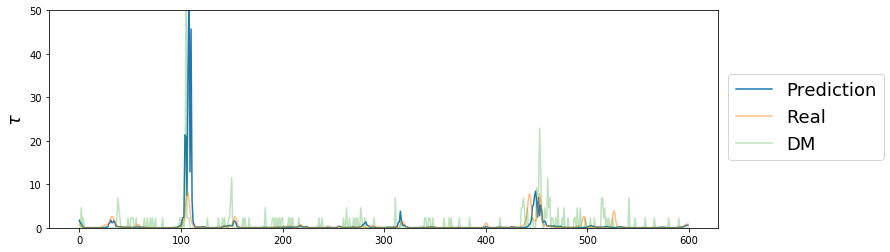

In [ ]:
ii = np.random.randint(low=0, high=test_len-1, size=1)[0].astype('int')
plt.figure(figsize=(12,4))
plt.plot( -np.log(1-test_outp[ii]), label='Predicted' )
plt.plot( -np.log(1-test_ske[ii]), label='Real', alpha=0.5 )
plt.plot( DM_general[0, int(test_block[ii,0]/DM_reso), int(test_block[ii,1]/DM_reso), :].numpy(), label='DM', alpha=0.3 )
plt.ylabel(r'$\tau$', fontsize=18)
plt.ylim([0,5])
#plt.yscale('log')
plt.legend(fontsize=18, bbox_to_anchor=(1.26,0.75))

plt.figure(figsize=(12,4))
plt.plot( (1-test_outp[ii]), label='Predicted', alpha=0.7 )
plt.plot( (1-test_ske[ii]), label='Real', alpha=0.5 )
#plt.plot( DM_general[0, int(test_block[ii,0]/DM_reso), int(test_block[ii,1]/DM_reso), :].numpy(), label='DM', alpha=0.3 )
plt.ylabel(r'$F = \mathrm{e}^{-\tau}$', fontsize=18)
plt.ylim([-0.1, 1.1])
#plt.yscale('log')
plt.legend(fontsize=18, bbox_to_anchor=(1.26,0.75))